# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Imports 
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import zipfile
import os
from urllib.request import urlretrieve
import cv2
import sklearn.model_selection

%matplotlib inline

In [2]:
# Name of the model to be used. If None, the network will be retrained
network_model_dir = None#'model/20161126_094622'

## Step 0: Dataset Download
Download link: https://d17h27t6h515a5.cloudfront.net/topher/2016/October/5811165e_traffic-signs-data.zip/traffic-signs-data.zip.zip

Rename train.p and test.p to train.pickle and test.pickle, respectively

In [3]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')

download('https://d17h27t6h515a5.cloudfront.net/topher/2016/October/5811165e_traffic-signs-data.zip/traffic-signs-data.zip.zip', 'traffic-signs-data.zip.zip')


File already in the filesystem!


In [4]:
train_filename = 'train.pickle'
test_filename = 'test.pickle'

if not os.path.isfile(train_filename) or not os.path.isfile(test_filename):
    # Unzip
    print('Unzipping file...')
    with zipfile.ZipFile("traffic-signs-data.zip.zip","r") as zip_ref:
        zip_ref.extractall()

    # Rename    
    print('Renaming pickle files...')
    os.rename('train.p', 'train.pickle')
    os.rename('test.p', 'test.pickle')
    print('Done')
else:
    print('Pickle files already in the filesystem!')


Pickle files already in the filesystem!


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [5]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.pickle'
testing_file = 'test.pickle'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [8]:
# Shapes of the input arrays
print("X_train.shape = ", X_train.shape)
print("y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  (39209, 32, 32, 3)
y_train.shape =  (39209,)
X_test.shape =  (12630, 32, 32, 3)
y_test.shape =  (12630,)


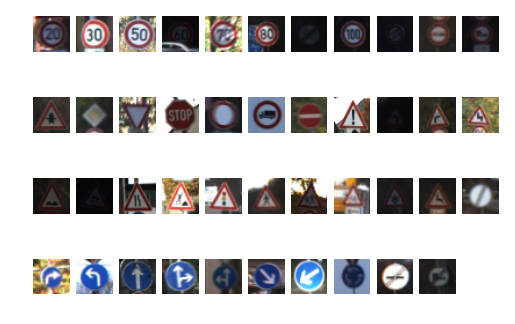

In [9]:
# Plot one example of the 43 different classes
_, idx = np.unique(y_test, return_index=True)
X_test_unique = X_test[idx, :, :, :]
for i in range(0, len(idx)):
    plt.subplot(4, 11, i+1);
    plt.imshow(X_test_unique[i, :, :, :]);
    plt.axis('off');

In [10]:
# Print the labels
labels_text = []
with open('signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in reader:
        print(', '.join(row))        
        if i > 0:
            labels_text.append(row[1])        
        i = i + 1

ClassId, SignName
0, Speed limit (20km/h)
1, Speed limit (30km/h)
2, Speed limit (50km/h)
3, Speed limit (60km/h)
4, Speed limit (70km/h)
5, Speed limit (80km/h)
6, End of speed limit (80km/h)
7, Speed limit (100km/h)
8, Speed limit (120km/h)
9, No passing
10, No passing for vechiles over 3.5 metric tons
11, Right-of-way at the next intersection
12, Priority road
13, Yield
14, Stop
15, No vechiles
16, Vechiles over 3.5 metric tons prohibited
17, No entry
18, General caution
19, Dangerous curve to the left
20, Dangerous curve to the right
21, Double curve
22, Bumpy road
23, Slippery road
24, Road narrows on the right
25, Road work
26, Traffic signals
27, Pedestrians
28, Children crossing
29, Bicycles crossing
30, Beware of ice/snow
31, Wild animals crossing
32, End of all speed and passing limits
33, Turn right ahead
34, Turn left ahead
35, Ahead only
36, Go straight or right
37, Go straight or left
38, Keep right
39, Keep left
40, Roundabout mandatory
41, End of no passing
42, End of n

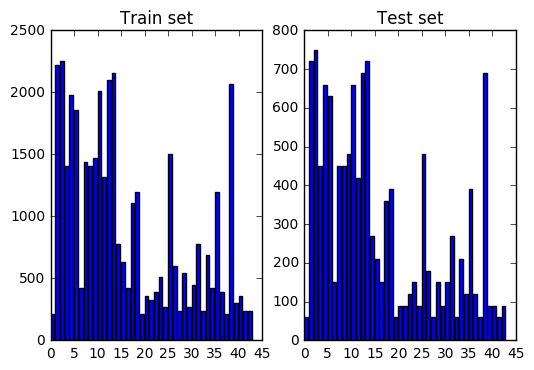

In [11]:
# Display the number of examples for each class, for training and test set
def get_class_distribution(y, n_classes):
    labels = np.array(range(0, n_classes))
    n_examples = np.zeros(n_classes, dtype=np.int32)
    for i in labels:
        # Get indices in Y that correspond to 'i', for train and test sets
        n_examples[i] = sum(y == i)
        
    return (labels, n_examples)
    
# Plot in a bar diagram
plt.subplot(1,2,1)
labels, dist_train = get_class_distribution(y_train, n_classes)
plt.bar(labels, dist_train);
plt.title('Train set');
plt.subplot(1,2,2)
labels, dist_test = get_class_distribution(y_test, n_classes)
plt.bar(labels, dist_test);    
plt.title('Test set');

We can observe that the training data is **not equally distributed** among the different classes. This indicates that the algorithm will be more fine-tuned for those classes for which there are more examples. If we want to improve the network's ability to generalize, we should have roughly the same number of examples for each class. 

The training set is balanced at the same time as fake data is generated, as shown in the following sections.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Fake data generation
We generate fake data in order for the network to be more robust and prevent overfitting. The following transformations are applied to each image of the training set, which is extended:

  * Translation
  * Rotation
  * Scaling
  * Shearing  
 
We do not apply all 4 transformations at the same time to the image, because the bilinear interpolation in cv2.warpAffine makes the output image a bit blurrier every step. After applying the process 4 times, the image is too blurry to get good features. Therefore we opt for randomly choose one of those functions.

The dataset becomes then 10x bigger than the previous.

In [13]:
### Helper functions
def apply_affine_transform(img, T):
    rows, cols, ch = img.shape
    return cv2.warpAffine(img, T, (cols, rows))

def random_translate(img, max_relative_displacement = 0.1):
    h, w =  img.shape[0:2]
    
    tx = np.random.uniform(-max_relative_displacement * w, max_relative_displacement * w)
    ty = np.random.uniform(-max_relative_displacement * h, max_relative_displacement * h)
    
    T = np.array([[1.0, 0.0, tx], [0.0, 1.0, ty]], dtype = np.float32)

    return apply_affine_transform(img, T)

def random_rotate(img, max_angle_degrees = 5.0):
    theta = np.random.uniform(-max_angle_degrees, max_angle_degrees) * np.pi/180.0
    
    c = np.cos(theta)
    s = np.sin(theta)
    
    T = np.array([[c, -s, 0.0], [s, c, 0.0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def random_scale(img, max_scale_factor = 0.05):    
    sx = 1.0 + np.random.uniform(-max_scale_factor, max_scale_factor)
    sy = 1.0 + np.random.uniform(-max_scale_factor, max_scale_factor)
    
    T = np.array([[sx, 0.0, 0.0], [0.0, sy, 0.0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def random_shear(img, max_sheer_factor = 0.05):
    kx = np.random.uniform(-max_sheer_factor, max_sheer_factor)
    ky = np.random.uniform(-max_sheer_factor, max_sheer_factor)
    
    T = np.array([[1.0, kx, 0.0], [ky, 1.0, 0]], dtype = np.float32)
    return apply_affine_transform(img, T)

def jitter_image(img):
    fnc = np.random.randint(0, 4)
    
    if fnc == 0:
        return random_translate(img)    
    elif fnc == 1:
        return random_rotate(img)    
    elif fnc == 2:
        return random_scale(img)
    else:
        return random_shear(img)        
    
def generate_fake_data(X, y, old_class_distribution, extend_factor = 10):
    X_fake = []
    y_fake = []
    
    # Get minimum final size of dataset, as well as nr of images per class
    final_size = extend_factor * X.shape[0]
    n_classes = len(old_class_distribution)
    n_images_per_class = int(np.ceil(final_size / n_classes))
    
    for i in range(X.shape[0]):
        # Compute number of required images
        class_idx = y[i]
        current_distribution_i = old_class_distribution[class_idx]        
        n_fake_images = int(np.ceil((n_images_per_class - current_distribution_i) / current_distribution_i))        
        
        # Generate fake images
        for j in range(n_fake_images):
            X_fake.append(jitter_image(X[i]))
            y_fake.append(y[i])
        
    return (np.array(X_fake), np.array(y_fake))

def extend_training_data(X, y, old_class_distribution):
    X_fake, y_fake = generate_fake_data(X, y, old_class_distribution)
    
    X = np.concatenate((X, X_fake), axis = 0)
    y = np.concatenate((y, y_fake), axis = 0)
    
    return (X, y)   

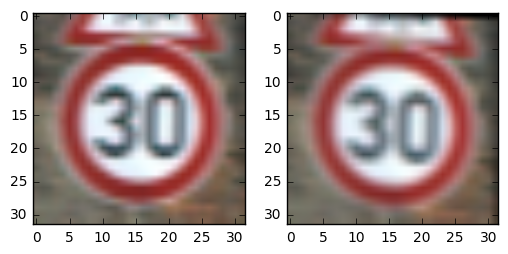

In [14]:
x_in = X_train[1000]
x_out = jitter_image(x_in)

plt.subplot(1,2,1)
plt.imshow(np.squeeze(x_in), cmap='gray');
plt.subplot(1,2,2)
plt.imshow(np.squeeze(x_out), cmap='gray');

Extended training set size:  (413776, 32, 32, 3)


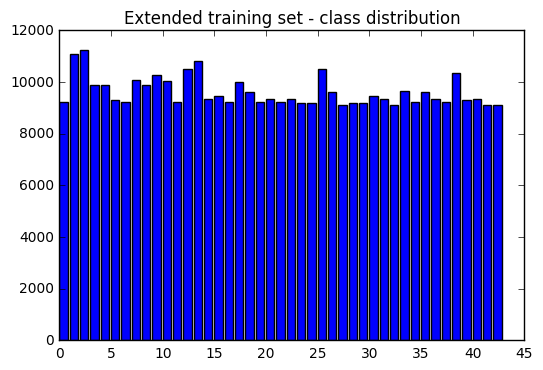

In [15]:
# Extended training set with fake data
_, old_distribution = get_class_distribution(y_train, n_classes)
X_train, y_train = extend_training_data(X_train, y_train, old_distribution)
print('Extended training set size: ', X_train.shape)

# Plot new class distribution. It should be close to a uniform distribution
labels, dist_train = get_class_distribution(y_train, n_classes)
plt.bar(labels, dist_train);
plt.title('Extended training set - class distribution');

We can see that the training set is now balanced, so it will not be biased towards some classes.

### Data preprocessing

In [16]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [17]:
### RGB to grayscale conversion. According to the paper, it gives better results
def rgb_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

### Normalization: zero mean and unit variance
def normalization(x):
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255
    
    return a + (x - x_min) * (b - a) / (x_max - x_min)

def preprocess_set(dataset):
    # Declare output array
    shape = [x for x in dataset.shape]
    shape[3] = 1 # Will convert to grayscale
    dataset_preprocessed = np.zeros(shape)
    
    # Convert from RGB to grayscale
    for i in range(0, dataset.shape[0]):
        dataset_preprocessed[i, :, :, :] = np.expand_dims(rgb_to_grayscale(dataset[i, :, :]), axis=2)
    
    #dataset_preprocessed = dataset
        
    # Perform normalization
    dataset_preprocessed = normalization(dataset_preprocessed)
    
    return dataset_preprocessed

def one_hot_encoding(y_data, depth):
    return np.eye(depth)[y_data]

In [18]:
print('Preprocessing train and test datasets...')
X_train_preprocessed = preprocess_set(X_train)
X_test_preprocessed = preprocess_set(X_test)

y_train_preprocessed = one_hot_encoding(y_train, depth = n_classes)
y_test_preprocessed = one_hot_encoding(y_test, depth = n_classes)
print('Done')

Preprocessing train and test datasets...
Done


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The following techniques have been used to preprocess the data:

* **RGB to grayscale conversion**. According to the paper, this results in a slightly better performance. In addition, this will make our network easier to train, since the input is a 32x32x1 image instead of 32x32x3. Besides, by examining the different signs to identify, we observe that there is sufficient information in the shape of the sign and its contents to rely on grayscale information. A different case would have been to classify between 'normal' signs and 'on-road work' signs, which are distinguished only by the background color in Europe (white/yellow).

* **Normalization**. We implement a min-max scaling in the same way as it was done in the TensorFlow lab, given the good performance obtained. Another approach would have been to make each test image of zero mean and unit variance, but this would have taken considerably more time. Considering that the dataset (after generating fake data) is relatively big, we opted for a computationally cheaper solution.

### Dataset splitting

Training set
Validation set


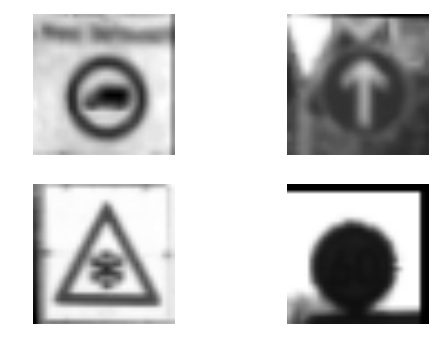

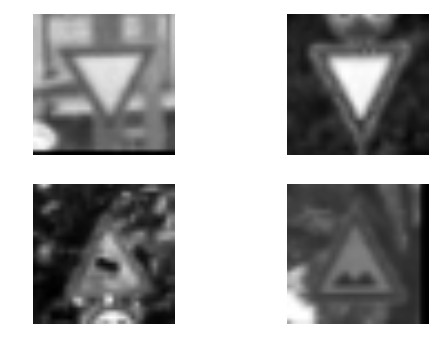

In [19]:
### Dataset splitting
validation_size = 0.1
X_train_final, X_dev_final, y_train_final, y_dev_final = \
sklearn.model_selection.train_test_split(X_train_preprocessed, y_train_preprocessed, random_state=918273645)

# Plot a few images to see if they look good
print('Training set')
plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1);
    plt.imshow(np.squeeze(X_train_final[i, :, :, :]), cmap='gray');
    plt.axis('off');

print('Validation set')
plt.figure();
for i in range(4):
    plt.subplot(2, 2, i + 1);
    plt.imshow(np.squeeze(X_dev_final[i, :, :, :]), cmap='gray');
    plt.axis('off');

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

#### Dataset splitting
We start with two datasets: `X_train_preprocessed`, `y_train_preprocessed`. In order to evaluate the performance of the network while tweaking its hyperparameters we must not use `y_train_preprocessed`, since we would indirectly be overfitting to this data. Instead, we create a **validation set**, that we use for evaluating the performance of the network. It's also usually called _development set_. This set is a subset of the complete `X_train_preprocessed` set. We perform the splitting using the `sklearn.model_selection.train_test_split` function.

In summary, the following 3 datasets are used in the following:

* `X_train_final`: 90% of `X_train_preprocessed`
* `X_dev_final`: 10% of `X_train_preprocessed`
* `y_train_final`: `y_train_preprocessed` (unchanged)

We choose a 10% split rate because we want to use as much data for training as possible. Given that the extended dataset is pretty big (around 400000 images), a 10% is already enough to have a reasonable certainty that the results are solid.

#### Fake data generation
After training on the raw dataset, we observed that the network had a not good enough performance on the test set (around 87%). As some students pointed out in the forums, the main reason for this is insufficient training data. Therefore we generated an additional number of jittered versions of each image. This proves to be a very powerful solution against overfitting and provides robustness against affine transformations in the image. 
The fake dataset could have been extended by jittering the color, adding noise to the image, etc. We generate a different number of extra images for each class, so that the overall training dataset is balanced.

---
## 2.1. Network architecture

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### 2.1.1 Helper functions

In [21]:
### Helper functions
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))    
    
def create_biases(shape):    
    return tf.Variable(tf.zeros(shape) + 0.05)

def flatten_layer(layer):
    # Shape is [batch_size, img_h, img_w, img_depth]    
    layer_shape = layer.get_shape()
    
    # Number of features per image
    num_features = layer_shape[1:4].num_elements()
    
    # Must reshape into [batch_size, n_features]. Since the batch_size is unknown
    # we type -1 so tf will figure it out itself
    return tf.reshape(layer, [-1, num_features])

### 2.1.2 Convolutional layer

This function creates a convolutional layer, taking as input a 4D tensor of shape [batch_size, width, height, depth]. The parameters are the filter size, number of filters, and options to include a Max Pooling layer, ReLU and Dropout.

In [22]:
def create_conv_layer(input_layer,               # 4D tensor
                      filter_size,               # scalar
                      n_filters,                 # scalar
                      use_pooling=True,          # boolean
                      use_relu=True,             # boolean
                      dropout_keep_prob=None     # tensor variable
                     ):    
    # Review https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d
    # for conventions about input shapes

    # Create weights (4D tensor) and biases (1D vector)
    input_depth = int(input_layer.get_shape()[3])
    weight_shape = [filter_size, filter_size, input_depth, n_filters]
    bias_shape = [n_filters]
    
    weights = create_weights(weight_shape)
    biases = create_biases(bias_shape)
    
    # Convolution
    layer = tf.nn.conv2d(input=input_layer, 
                         filter=weights,
                         strides=[1,1,1,1], 
                         padding='SAME')
    # Add bias
    layer = tf.nn.bias_add(layer, biases)
    
    # Max pooling
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1,2,2,1],
                               strides=[1,2,2,1],
                               padding='SAME')
    
    # ReLU. Should be applied before pooling. However the result is the same and in this
    # case we perform fewer computations, since there are fewer pixels
    if use_relu:
        layer = tf.nn.relu(layer)
    
    # Dropout
    if dropout_keep_prob is not None:
        layer = tf.nn.dropout(layer, dropout_keep_prob)
    
    return layer


### 2.1.3 Fully-connected layer
This function creates a fully connected layer, taking as input a 2D matrix of shape [batch_size, n_features] and having a number of outputs as a parameter. It also includes an optional boolean argument to include ReLU and dropout.

In [23]:
def create_fc_layer(input_layer,               # 2D matrix [batch_size, n_inputs]
                    n_outputs,                 # scalar
                    use_relu=True,             # scalar
                    dropout_keep_prob=None     # tensor variable
                   ):        

    n_inputs = int(input_layer.get_shape()[1])
    weights = create_weights([n_inputs, n_outputs])
    biases = create_biases([n_outputs])
    
    # XW + b
    layer = tf.matmul(input_layer, weights)
    layer = tf.nn.bias_add(layer, biases)
    
    # ReLU
    if use_relu:
        layer = tf.nn.relu(layer)
    
    # Dropout
    if dropout_keep_prob is not None:
        layer = tf.nn.dropout(layer, dropout_keep_prob)
    
    return layer   

### 2.1.4 Network parameter design
In the following code cell, we define the sizes of the layers of the convolutional neural network.

In [24]:
### Network parameters
# Input
img_size_w = X_train_final.shape[1]
img_size_h = X_train_final.shape[2]
img_size_d = X_train_final.shape[3]
img_size_total = img_size_w * img_size_h * img_size_d

# Conv layer 1
conv1_filter_size = 5
conv1_n_filters = 16

# Conv layer 2
conv2_filter_size = 5
conv2_n_filters = 32

# Conv layer 3
conv3_filter_size = 5
conv3_n_filters = 64

# Fully Connected 1
fc1_n_neurons = 512

# Fully Connected 2
fc2_n_neurons = n_classes

### 2.1.5 Placeholder variables
This code cell contains placeholder variables, i.e. variables that we feed with data inside the TensorFlow session.

In [25]:
### Placeholder variables
# Input: batch of images - 4D tensor [batch_size, img_h, img_w, img_d]
x = tf.placeholder(tf.float32, shape=[None, img_size_h, img_size_w, img_size_d])

# Output: true class - 2D matrix, one-hot encoded value [batch_size, n_classes]
y_true = tf.placeholder(tf.float32, shape=[None, n_classes])

# True class (not hot encoded) vector [batch_size]
y_true_class = tf.argmax(y_true, dimension=1)

# Dropout keep probability
dropout_keep_p = tf.placeholder(tf.float32)

print('x = ', x)
print('y_true = ', y_true)

x =  Tensor("Placeholder:0", shape=(?, 32, 32, 1), dtype=float32)
y_true =  Tensor("Placeholder_1:0", shape=(?, 43), dtype=float32)


### 2.1.6 Network implementation
After implementing some helper functions and designing the network, now we include code cells that actually implement each one of the layers of the convolutional neural network.

In [26]:
### Network architecture
# First Layer: Conv + ReLU + Max pool
conv1 = create_conv_layer(input_layer=x,
                          filter_size=conv1_filter_size,
                          n_filters=conv1_n_filters,
                          use_pooling=True,
                          use_relu=True,
                          dropout_keep_prob=dropout_keep_p)
print("Layer 1 = ", conv1)


Layer 1 =  Tensor("dropout/mul:0", shape=(?, 16, 16, 16), dtype=float32)


In [27]:
# Second Layer: Conv + ReLU + Max pool
conv2 = create_conv_layer(input_layer=conv1,
                          filter_size=conv2_filter_size,
                          n_filters=conv2_n_filters,
                          use_pooling=True,
                          use_relu=True,
                          dropout_keep_prob=dropout_keep_p)
print("Layer 2 = ", conv2)

Layer 2 =  Tensor("dropout_1/mul:0", shape=(?, 8, 8, 32), dtype=float32)


In [28]:
# Third Layer: Conv + ReLU + Max pool
conv3 = create_conv_layer(input_layer=conv2,
                          filter_size=conv3_filter_size,
                          n_filters=conv3_n_filters,
                          use_pooling=True,
                          use_relu=True,
                          dropout_keep_prob=dropout_keep_p)
print("Layer 3 = ", conv3)

Layer 3 =  Tensor("dropout_2/mul:0", shape=(?, 4, 4, 64), dtype=float32)


In [29]:
# Fourth Layer: Fully Connected + ReLU
flattened_conv3 = flatten_layer(conv3)
print(flattened_conv3)
fc1 = create_fc_layer(input_layer=flattened_conv3,
                      n_outputs=fc1_n_neurons,
                      use_relu=True,
                      dropout_keep_prob=dropout_keep_p)
print("FC 1 = ", fc1)

Tensor("Reshape:0", shape=(?, 1024), dtype=float32)
FC 1 =  Tensor("dropout_3/mul:0", shape=(?, 512), dtype=float32)


In [30]:
# Fifth Layer: Fully Connected
# NOTE: ReLU is not used, since the output will go directly to the Softmax function
fc2 = create_fc_layer(input_layer=fc1,
                      n_outputs=fc2_n_neurons,
                      use_relu=False,
                      dropout_keep_prob=None)
print("FC 2 = ", fc2)

FC 2 =  Tensor("BiasAdd_4:0", shape=(?, 43), dtype=float32)


In [31]:
# Softmax
y_predicted = tf.nn.softmax(fc2)
y_predicted_class = tf.argmax(y_predicted, dimension=1)
print(y_predicted)

Tensor("Softmax:0", shape=(?, 43), dtype=float32)


In [32]:
### Optimization
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### 2.1.7 Performance evaluation
Finally, we define the computations required in order to obtain the training, validation and test accuracy, with which we can evaluate the performance of the proposed network.

In [33]:
### Performance evaluation
# Check if the predicted class is equal to the true class
is_correct_prediction = tf.equal(y_predicted_class, y_true_class)

# Compute the accuracy by averaging out the previous variable
accuracy = 100.0 * tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The architecture is shown in Figure 1, greatly inspired by the paper cited above.

![alt text](res/P2-CNN.png "Figure 1: Network Architecture")


It can be seen that it is a convolutional neural network, composed to:

0. **Preprocessing step**. The input image (RGB) of 32x32x3 pixels is transformed into grayscale and normalized.

1. **First Layer**: convolutional. Takes an input of 32x32x1 pixels and convolves it with 16 5x5x1 filters. Maxpooling reduces the size of the output by a half, obtaining 16x16x16. Dropout is used.

2. **Second layer**: convolutional. Takes an input of 16x16x16 pixels, and convolves with 32 5x5x1 filters. Again, maxpooling and dropout is used. The output is 8x8x32. 

3. **Third layer**: convolutional. Takes an input of 8x8x32 pixels, and convolves with 64 5x5x1 filters. Maxpooling and dropout are used. The output is 4x4x64. As can be seen, the convolutional layers form a pyramid, where the image size is reduced but the depth is increased.

3. **Fourth layer**: fully connected. We first flatten the previous input to a 1024
feature vector. The layer has 512 neurons.

4. **Fifth layer**: takes the previous 512-vector and outputs 43 neurons, the number
of classes. ReLU and dropout are not used, since the output is directly connected to the classifier.

5. **Classifier**, consisting on a `softmax` function followed by `argmax` to determine the most likely class for the given input. 

It's also worth mentioning that the filtering operations were performed using 'SAME' padding, in order to keep the dimensions of the original image, with stride of 1. The max pooling operation had stride 2 in order to reduce by 2 the size of the image and create a pyramid-like network.

The model is relatively simple (only 3 convolutional and 2 fully-connected layers), but it proves itself to be very powerful.

---
## 2.2 Network training

In [34]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [35]:
# Training paramters
n_epochs = 200
train_batch_size = 128
test_batch_size = 128

n_batches = int(np.floor(X_train_final.shape[0] / train_batch_size))

print ("Training the network for %d epochs." % n_epochs)
print ("The batch size is %d, and there are %d training examples, so we use %d batches per epoch" % (train_batch_size, X_train_final.shape[0], n_batches))

Training the network for 200 epochs.
The batch size is 128, and there are 310332 training examples, so we use 2424 batches per epoch


In [36]:
# Helper function to get a batch from a dataset
def get_batch(x, y, batch_size, batch_idx):
    max_size = x.shape[0]
    start_idx = batch_idx * batch_size

    x_batch = x[start_idx : np.minimum(start_idx + batch_size, max_size), :, :, :]
    y_batch = y[start_idx : np.minimum(start_idx + batch_size, max_size), :]
    
    return (x_batch, y_batch)

In [37]:
def get_test_accuracy(x_data, y_data, batch_size):
    n_batches = int(np.ceil(x_data.shape[0] / batch_size))
    accuracies = np.zeros([n_batches])

    for i in range(n_batches):
         # Get batch
        batch_x, batch_y = get_batch(x_data, y_data, batch_size, i)
        
        # Create feed dictionary
        feed_data = {x: batch_x, y_true: batch_y, dropout_keep_p: 1.0}

        # Feed it to the network and update the weights
        accuracies[i] = sess.run(accuracy, feed_dict=feed_data)
       
    return np.mean(accuracies)

In [38]:
# Create TensorFlow session
sess = tf.Session()

In [39]:
# Train network
training_accuracy = []
validation_accuracy = []

desired_validation_acc = 99.5  # %

if network_model_dir is None:
    # Initialize variables
    sess.run(tf.initialize_all_variables())

    shuffle_idx = np.arange(0, X_train_final.shape[0])

    for i_epoch in range(n_epochs):
        # Shuffle training data
        np.random.shuffle(shuffle_idx)   
        X_train_final = X_train_final[shuffle_idx]
        y_train_final = y_train_final[shuffle_idx]

        # Loop through batches
        for i_batch in range(n_batches):
            # Get batch
            batch_x_train, batch_y_train = get_batch(X_train_final, y_train_final, train_batch_size, i_batch)

            # Create feed dictionary
            feed_data_train = {x: batch_x_train, y_true: batch_y_train, dropout_keep_p: 0.5}

            # Feed it to the network and update the weights
            sess.run(optimizer, feed_dict=feed_data_train)       

        # Compute the training and validation accuracy for each epoch
        feed_data_train_acc = {x: batch_x_train, y_true: batch_y_train, dropout_keep_p: 1.0}    
        training_acc_i = sess.run(accuracy, feed_data_train_acc)

        validation_acc_i = get_test_accuracy(X_dev_final, y_dev_final, test_batch_size)

        training_accuracy.append(training_acc_i )
        validation_accuracy.append(validation_acc_i)
        print('Epoch %3d - training acc: %3.1f%%, validation acc: %3.1f%%'
              % (i_epoch, training_acc_i, validation_acc_i))

        # Exit if conditions met
        if validation_acc_i > desired_validation_acc:
            print('Reached validation accuracy of %3.1f%%! Finished training...'
                  % (validation_acc_i))
            break

Epoch   0 - training acc: 29.7%, validation acc: 27.8%
Epoch   1 - training acc: 59.4%, validation acc: 62.1%
Epoch   2 - training acc: 76.6%, validation acc: 76.3%
Epoch   3 - training acc: 82.0%, validation acc: 83.5%
Epoch   4 - training acc: 85.2%, validation acc: 87.7%
Epoch   5 - training acc: 90.6%, validation acc: 90.7%
Epoch   6 - training acc: 89.8%, validation acc: 92.6%
Epoch   7 - training acc: 93.0%, validation acc: 93.9%
Epoch   8 - training acc: 93.8%, validation acc: 95.0%
Epoch   9 - training acc: 94.5%, validation acc: 95.6%
Epoch  10 - training acc: 95.3%, validation acc: 96.2%
Epoch  11 - training acc: 97.7%, validation acc: 96.8%
Epoch  12 - training acc: 98.4%, validation acc: 97.1%
Epoch  13 - training acc: 98.4%, validation acc: 97.5%
Epoch  14 - training acc: 98.4%, validation acc: 97.6%
Epoch  15 - training acc: 99.2%, validation acc: 98.0%
Epoch  16 - training acc: 95.3%, validation acc: 98.0%
Epoch  17 - training acc: 98.4%, validation acc: 98.2%
Epoch  18 

It can be observed that the training accuracy is smaller than the validation accuracy. It even reached 100% a few times and then went down.

It's important to notice that this training accuracy is **not** as reliable as the validation accuracy, since it's only considering the error over a mini-batch (128 examples), whereas the validation accuracy uses the whole validation set (more than 40000 examples).

We only provide the training accuracy for completeness, but we train the network evaluating only the validation accuracy.

### 2.3 Saving network parameters

In [40]:
if network_model_dir is None:
    # Same the network parameters
    saver = tf.train.Saver()
    model_dir = os.path.join('model', time.strftime("%Y%m%d_%H%M%S"))
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    save_path = os.path.join(model_dir, 'model.ckpt')
    saver.save(sess, save_path);
    
    # Save metainfo about the training
    training_curve_file = os.path.join(model_dir, 'training_info.pickle')
    with open(training_curve_file, mode='wb') as f:
        pickle.dump({'training_acc': training_accuracy, 'validation_acc': validation_accuracy}, f)

### 2.4 Restoring network parameters

In [41]:
if network_model_dir is not None:
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join(network_model_dir, 'model.ckpt'))
                  
    training_info_file = os.path.join(network_model_dir, 'training_info.pickle')
    with open(training_info_file, 'rb') as f:
        d = pickle.load(f)
        
        training_accuracy = d['training_acc']
        validation_accuracy = d['validation_acc']

### 2.5 Displaying trainining information

Training accuracy: 99.2%
Validation accuracy: 99.5%


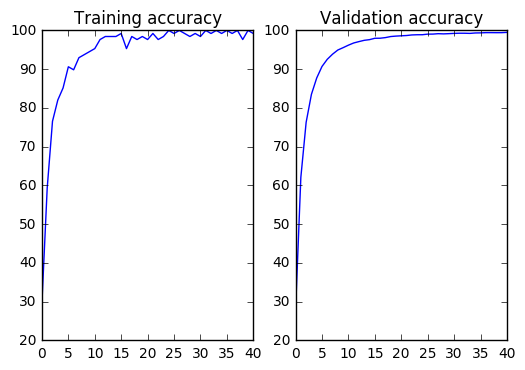

In [42]:
# Plot training and validation accuracy, and print the final value
iteration_vector = range(len(training_accuracy))

plt.subplot(121)
plt.plot(iteration_vector, np.array(training_accuracy));
plt.title('Training accuracy');

plt.subplot(122)
plt.plot(iteration_vector, np.array(validation_accuracy));
plt.title('Validation accuracy');

final_train_acc = training_accuracy[-1]
final_val_acc = validation_accuracy[-1]
   
print("Training accuracy: %.1f%%" % final_train_acc)
print('Validation accuracy: %.1f%%' % final_val_acc)      

Again, we observe that the training accuracy graph is very shaky and not monotonically increasing, compared to the validation graph. This is because the training accuracy is measured only over a mini-batch of 128 examples for each epoch, whereas the validation accuracy uses the whole validation set.

We can see that the learning process was very successful, reaching 99.5% accuracy in the validation set, which was never used for training.

### 2.6 Network evaluation on Test set

In [43]:
print('Test accuracy: %.1f%%' % get_test_accuracy(X_test_preprocessed, y_test_preprocessed, test_batch_size))

Test accuracy: 93.4%


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The model was trained using:

* **Cost function**: cross-entropy with logits, following the example from the MNIST TensorFlow Lab.

* **AdamOptimizer**. After watching lectures CS231n, it was observed that the GradientDescentOptimizer is not the best one, and actually pretty slow. AdamOptimizer was then recommended.

* **Learning rate**: 0.0001, as suggested in the following [TensorFlow tutorial](https://www.youtube.com/watch?v=HMcx-zY8JSg&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ). The documentation of AdapOptimizer suggests 0.001, but we found a smaller learning rate to provide slightly better results. It's already a fast optimizer, so it is better to step a bit slower and make sure the learning happens in a proper manner. 

* **Batch size**: 128 for both training and testing, in order to fit in GPU memory (4 GB). A power of 2 was chosen since GPU architectures can take advantage of this for more efficient processing.

* **Dropout keep probability**: 0.5 for training and 1.0 for testing, as suggested in the lectures. This was extremely powerful to make the network more robust and prevent from overfitting.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The approach to solving the traffic sign recognition problem was to use a convolutional neural network. These type of networks are well suited for image processing problems (since convolutions are typical operations on them), 
and the number of required parameters is much smaller (since the weights are shared for every pixel in the image).

The main reference was the paper cited above, where they propose a 2 conv + 2 FC network architecture. Many TensorFlow tutorials used this approach so it seemed like a robust and well-studied solution. 

The following additions over the basic network pushed the test accuracy from around 87% to 93.4%:

* Added an extra convolutional layer. This bumped the accuracy to around 89%.

* Added dropout, which significantly improved the test accuracy, bumping it to around 92%.

* Generated fake data, giving the final push on the accuracy to 93.4%. It also helped a lot to increase the accuracy in my own images, since the training distribution was balanced.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [44]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [45]:
# Helper functions to process the input images
def load_img(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def crop_img(img, crop_info):
    crop_x1 = crop_info[0]
    crop_y1 = crop_info[1]
    crop_size = crop_info[2]
    
    return img[crop_y1:crop_y1 + crop_size, crop_x1:crop_x1 +  crop_size, :]
    
def resize_img(img, new_size):
    return cv2.resize(img, new_size)

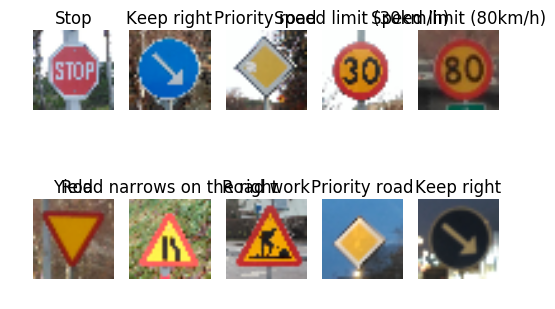

In [46]:
# Read CSV containing: image path, crop_x, crop_y, class
test_img_csv = 'test_img/test_img.csv'

n_tests = 10
X_test_own = np.zeros([n_tests, img_size_h, img_size_w, 3], dtype=np.float32)
y_test_own_labels = np.zeros([n_tests], dtype=int)

resize_size = (img_size_h, img_size_w)

with open(test_img_csv, 'r') as csvfile:
    i_img = 0
    reader = csv.reader(csvfile, delimiter=',')    
    for row in reader:
        # Read information from CSV file
        filename = row[0]
        crop_info = np.array(row[1:4], dtype=int)
        img_class = row[4]
        
        # Update test set
        img = load_img(filename)
        img = crop_img(img, crop_info)
        img = resize_img(img, resize_size)
        
        X_test_own[i_img, :, :, :] = img
        y_test_own_labels[i_img] = labels_text.index(img_class);
        
        # Plot image
        plt.subplot(2, 5, i_img+1)
        plt.imshow(img);
        plt.title(img_class);
        plt.axis('off')
        i_img = i_img + 1

# Preprocessing
X_test_own = preprocess_set(X_test_own)
y_test_own = one_hot_encoding(y_test_own_labels, n_classes)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

We have taken 10 images from the street, as shown in the picture above. The first two of them are pretty standard and should be easy to identify (stop, keep right). The third one has an sticker on it and a tree in the background which could pose some difficulty. The next two signs are speed limit signs, but with yellow background (indicating road work). This could pose problems for the network as it hasn't seen road work speed limits before. The following 3 signs have triangular shape but different symbols inside, so the network must recognize not only the external shape. 

Finally, the last two images correspond to night pictures, where the signs show up much blurrier and with less illumination. This tests the network under a completely different illumination condition, a typical problem in Computer Vision.

In [47]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [48]:
# Prediction
y_pred_own_class = sess.run(y_predicted_class, feed_dict={x: X_test_own, dropout_keep_p: 1.0})

for i in y_pred_own_class.astype(int):
    print(labels_text[i])

Stop
Keep right
Priority road
Speed limit (20km/h)
Speed limit (80km/h)
Yield
Road narrows on the right
Road work
Priority road
Keep right


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

It's hard to reach conclusions with only a few pictures, but we can say it performs fairly well. It could correctly classify 9 of out 10 images, so 90% accuracy. However we should not compare this result with the test set accuracy (over 93%), since the latter set is much bigger, therefore more representative of the actual accuracy of the network.

More on the analysis of the results in Question 8.

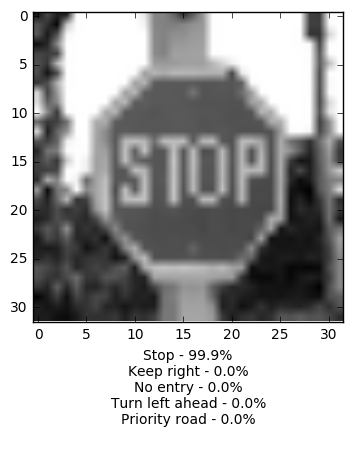

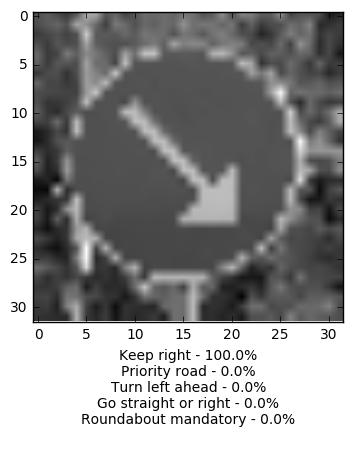

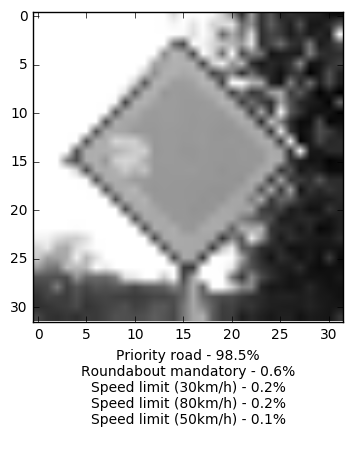

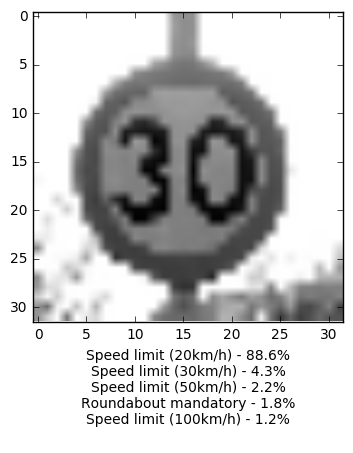

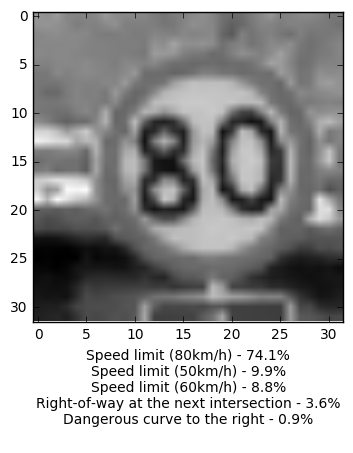

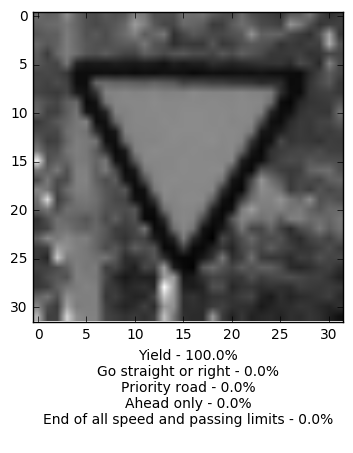

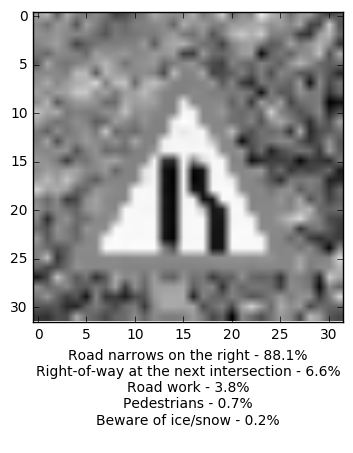

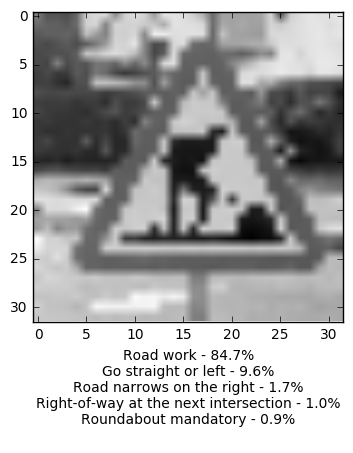

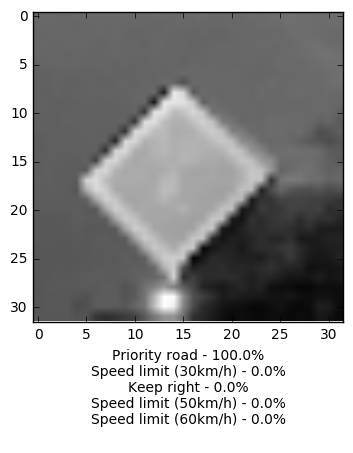

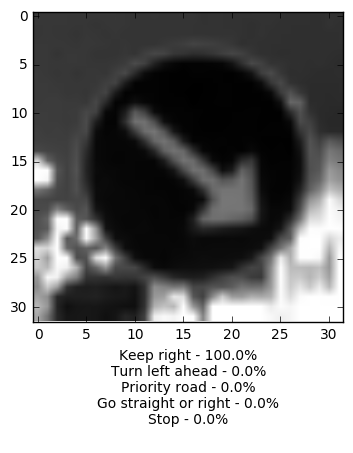

In [49]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_k_classes = 5
y_pred_own_top_k_prob = tf.nn.top_k(y_predicted, top_k_classes);

y_pred_own_prob, y_pred_own_idx = sess.run(y_pred_own_top_k_prob, feed_dict={x: X_test_own, dropout_keep_p: 1.0})

for i in range(X_test_own.shape[0]):
    plt.figure();
    plt.imshow(np.squeeze(X_test_own[i, :, :, :]), cmap='gray')
    text = ''
    for j in range(top_k_classes):
        text += labels_text[y_pred_own_idx[i, j]] + ' - %.1f%%' % (100.0 * y_pred_own_prob[i,j]) + '\n'
    plt.xlabel(text);    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

We notice that the correct predictions had a huge confidence, very close to 100%, which is very positive.

The only missclasiffied image was the 30 km/h speed sign, so the network did not learn the numbers very well. However we can observe the top 5 probabilities and realize that the network was not that far anyway, since the correct option is the second with highest probability. In addition, all the top-5 outputs are speed limits, so at least the network learnt that.

The positive aspect is that the reported prediction confidence for the missclassified sign is not close to 100%, compared to the successfully predicted classes, so we would normally not take this as a valid prediction and would let the network try again with a new image.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The main interface for testing on new images is based on the CSV file `test_img/test_img.csv`. 
Each row represents a test example, in the form:
    
    `path-to-img, crop_top_left_x, crop_top_left_y, crop_size, sign_name`
    
Where:

* `path-to-img`: path to the image to test.
* `crop_top_left_x`: X coordinate of the top-left corner of the bounding box that contains the sign.
* `crop_top_left_y`: Y coordinate of the top-left corner of the bounding box that contains the sign.
* `crop_size`: size (in pixels) of the squared bounding box that contains the sign.
* `sign_name`: name of the sign. It must be one of the names available in `signnames.csv`

NOTE: the bounding box must be selected manually. It is recommended to keep the sign in the center, with around 10% extra margin around it for best performance. The network should be robust against displacements, rotations and scalings though.

If the test has been properly added to `test_img/test_img.csv`, the previous lines of code take care of loading and cropping the image, preprocessing it, feeding it to the network and output the output class, as well as the softmax probabilities.     

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.